# Signal vs. background classification with NEW full MC

In [1]:
%matplotlib inline
from matplotlib.patches         import Ellipse
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb
import keras.backend.tensorflow_backend as K

from __future__  import print_function
from scipy.stats import threshold

from keras.models               import Model, load_model
from keras.layers               import Input, Dense, MaxPooling3D, Convolution3D, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers           import SGD, Adam, Nadam         
#from keras.callbacks            import ReduceLROnPlateau !!!!!
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten
from keras                      import callbacks
from keras.regularizers         import l2, activity_l2

Using TensorFlow backend.


Load Data

In [2]:
Ntrain = 18000     # number of training events per sample
Ntot = 19000

# Signal events.
s_dat = tb.open_file('/home/jrenner/data/classification/NEW_training_MC_si_nopadding_nonorm_einfo.h5', 'r')
print(s_dat)
s_array = np.array(s_dat.root.maps)
x_t = s_array[:Ntrain]
x_v = s_array[Ntrain:Ntot]
y_t = np.ones([Ntrain, 1])
y_v = np.ones([Ntot-Ntrain, 1])

s_earray = np.array(s_dat.root.energies)

# Background events.
b_dat = tb.open_file('/home/jrenner/data/classification/NEW_training_MC_bg_nopadding_nonorm_einfo.h5', 'r')
print(b_dat)
b_array = np.array(b_dat.root.maps)
print("Concatenating datasets...")
x_t = np.concatenate([x_t, b_array[:Ntrain]])
x_v = np.concatenate([x_v, b_array[Ntrain:Ntot]])
y_bt = np.zeros([Ntrain, 1])
y_t = np.concatenate([y_t, y_bt])
y_bv = np.zeros([Ntot-Ntrain, 1])
y_v = np.concatenate([y_v, y_bv])

b_earray = np.array(b_dat.root.energies)

# Normalize
mval = max(np.max(s_array),np.max(b_array))
muval = np.mean(s_array)
sval = np.std(s_array)
print("Normalizing with max value of", mval, "(mean of", muval, "; sigma of ", sval, ")")
#x_t /= sval
#x_v /= sval

# Include the final dimension (single-channel).
print("Reshaping...")
#x_t = np.expand_dims(x_t, axis=1)
#x_v = np.expand_dims(x_v, axis=1)
#x_t = np.reshape(x_t, (len(x_t), 48, 48, 30, 1))
#x_v = np.reshape(x_v, (len(x_v), 48, 48, 30, 1 ))
print("Prepared", len(x_t), "training events and", len(x_v), "validation events.")

/home/jrenner/data/classification/NEW_training_MC_si_nopadding_nonorm_einfo.h5 (File) ''
Last modif.: 'Tue Dec 13 15:14:17 2016'
Object Tree: 
/ (RootGroup) ''
/energies (EArray(26242, 30), blosc(9)) ''
/maps (EArray(26242, 48, 48, 30), blosc(9)) ''

/home/jrenner/data/classification/NEW_training_MC_bg_nopadding_nonorm_einfo.h5 (File) ''
Last modif.: 'Tue Dec 13 15:14:10 2016'
Object Tree: 
/ (RootGroup) ''
/energies (EArray(19089, 30), blosc(9)) ''
/maps (EArray(19089, 48, 48, 30), blosc(9)) ''

Concatenating datasets...
Normalizing with max value of 0.195609 (mean of 1.44678e-05 ; sigma of  0.000476798 )
Reshaping...
Prepared 36000 training events and 2000 validation events.


In [3]:
lmodel = False
    
with K.tf.device('/gpu:1'):
    
    if(lmodel):
        incep = load_model('models/smallnet.h5')
    else:
        K.set_session(K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)))

        inputs = Input(shape=(48, 48, 30))
        cinputs = Convolution2D(32, 6, 6, border_mode='same', subsample=(1, 1), activation='relu',init='lecun_uniform', W_regularizer=l2(0.005))(inputs)
        #cinputs = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode='same', dim_ordering='default')(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=3, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        #cinputs = Convolution2D(8, 1, 1, border_mode='same', subsample=(1, 1), activation='relu',init='lecun_uniform', W_regularizer=l2(0.005))(cinputs)
        cinputs = Convolution2D(64, 2, 2, border_mode='same', subsample=(1, 1), activation='relu',init='lecun_uniform', W_regularizer=l2(0.002))(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=3, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        #cinputs = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same', dim_ordering='default')(cinputs)
        cinputs = Convolution2D(16, 1, 1, border_mode='same', subsample=(1, 1), activation='relu',init='lecun_uniform', W_regularizer=l2(0.002))(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=3, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        f1 = Flatten()(cinputs)
        f1 = Dense(output_dim=8, activation='relu', init='lecun_uniform', W_regularizer=l2(0.008))(f1)
        f1 = Dropout(.9)(f1)

        inc_output = Dense(output_dim=1, activation='sigmoid',init='lecun_uniform', W_regularizer=l2(0.01))(f1)
        incep = Model(inputs, inc_output)

        incep.compile(loss='binary_crossentropy',
                      optimizer=Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999,
                                      epsilon=1e-08, schedule_decay=0.004), metrics=['accuracy'])

        # Train the network
        lcallbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min'), 
                      callbacks.ModelCheckpoint('models/conv3d_200k.h', monitor='val_loss', save_best_only=True, mode='min')]

    incep.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 48, 48, 30)    0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 48, 48, 32)    34592       input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 48, 48, 32)    64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 48, 48, 64)    8256        batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [ ]:
hist = incep.fit(x_t, y_t, shuffle=True, nb_epoch=40, batch_size=100, verbose=1, validation_data=(x_v, y_v))

Train on 36000 samples, validate on 2000 samples
Epoch 1/40
36000/36000 [==============================] - 36s - loss: 0.7597 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/40
36000/36000 [==============================] - 34s - loss: 0.7188 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5010
Epoch 3/40
  500/36000 [..............................] - ETA: 31s - loss: 0.7112 - acc: 0.4920

In [97]:
incep.save('models/smallnet_reg.h5')

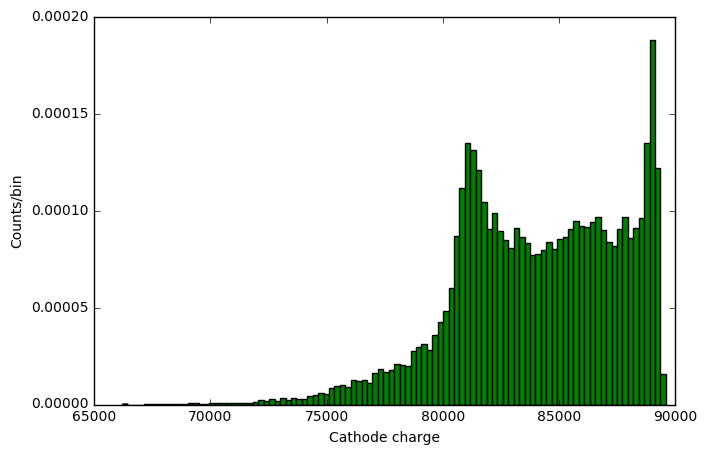

[  2.68801123e+03   2.21285156e+04   2.02682634e+04   2.38531240e+04
   4.84947485e+04   4.51021299e+04   3.80578799e+04   3.16746299e+04
   8.47889814e+04   1.38394760e+05   1.91312600e+05   2.55557562e+05
   8.38095117e+04   1.17624995e+04   3.02203364e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [8]:
# Plot the energies of the training events.
esums = []
for earr in s_earray:
    esums.append(np.sum(earr)/12.)
#for earr in b_earray:
#    esums.append(np.sum(earr))
    
fig = plt.figure();
ax1 = fig.add_subplot(111);
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(esums, 100, normed=1, facecolor='green')
plt.xlabel('Cathode charge')
plt.ylabel('Counts/bin')
plt.show()
print(b_earray[0])

In [17]:
# Carried over from NEW_kr_diff_mc_train.ipynb
def NEW_SiPM_map_plot(xarr, yarr, plot_truth=True, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(7.0)
    fig.set_figwidth(7.0)
    ax1.axis([-250, 250, -250, 250]);

    for i in range(48):
        for j in range(48):
            r = Ellipse(xy=(i * 10 - 235, j * 10 - 235), width=2., height=2.);
            r.set_facecolor('0');
            r.set_alpha(probs[i, j]);
            ax1.add_artist(r);
            
    if plot_truth:
        # Place a large blue circle for actual EL points.
        xpt = yarr[0]
        ypt = yarr[1]
        mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
        mrk.set_facecolor('b');
        ax1.add_artist(mrk);
        #print(xpt,ypt)
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

Plotting event 14900 slice 5 with charge sum 0.0227856 and total sum 1.0 max charge 0.00973584 and min charge 0.0


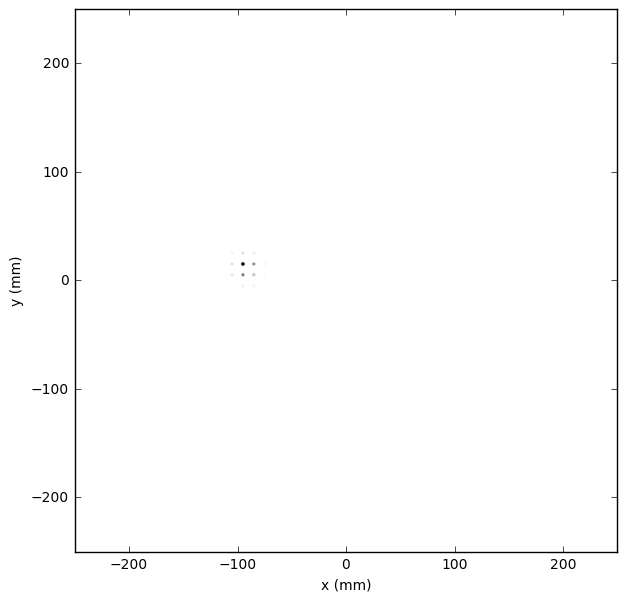

In [18]:
# Plot training event slices.
plt_nevt = 14900
plt_nslice = 5

plt_arr = x_t[plt_nevt,:,:,plt_nslice]
NEW_SiPM_map_plot(plt_arr,[0, 0], False)
chg_sum = np.sum(plt_arr)
tot_chg_sum = np.sum(x_t[plt_nevt,:,:,:])
max_chg = np.max(x_t[plt_nevt,:,:,plt_nslice])
min_chg = np.min(x_t[plt_nevt,:,:,plt_nslice])
print("Plotting event", plt_nevt, "slice", plt_nslice, "with charge sum", chg_sum, "and total sum", tot_chg_sum,
     "max charge", max_chg, "and min charge", min_chg)

In [ ]:
print(y_t[Ntrain])

In [ ]:
# Old nets
        cinputs = Convolution3D(32, 6, 6, 6, border_mode='same', subsample=(3, 3, 5), activation='relu',init='normal', W_regularizer=l2(0.001))(inputs)
        cinputs = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 3), border_mode='same', dim_ordering='default')(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        cinputs = Convolution3D(16, 1, 1, 1, border_mode='same', subsample=(1, 1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)
        cinputs = Convolution3D(32, 2, 2, 2, border_mode='same', subsample=(1, 1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same', dim_ordering='default')(cinputs)
        
        

        inputs = Input(shape=(48, 48, 30, 1))
        cinputs = Convolution3D(512, 6, 6, 6, border_mode='same', subsample=(3, 3, 5), activation='relu',init='normal', W_regularizer=l2(0.001))(inputs)
        cinputs = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 3), border_mode='same', dim_ordering='default')(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        cinputs = Convolution3D(64, 1, 1, 1, border_mode='same', subsample=(1, 1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)
        cinputs = Convolution3D(1024, 2, 2, 2, border_mode='same', subsample=(1, 1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same', dim_ordering='default')(cinputs)
        cinputs = Convolution3D(16, 1, 1, 1, border_mode='same', subsample=(1, 1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)
        #cinputs = Convolution3D(16, 3, 3, 3, border_mode='same', subsample=(2, 2, 2), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(32, 3, 3, 3, border_mode='same', subsample=(2, 2, 5), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(64, 2, 2, 2, border_mode='same', subsample=(2, 2, 1), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(512, 2, 2, 2, border_mode='same', subsample=(2, 2, 5), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(1024, 2, 2, 1, border_mode='same', subsample=(1, 1, 1), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(1024, 2, 2, 1, border_mode='valid', subsample=(3, 3, 1), activation='relu')(cinputs)
        f1 = Flatten()(cinputs)
        f1 = Dense(output_dim=1024, activation='relu', init='normal', W_regularizer=l2(0.001))(f1)
        f1 = Dropout(.4)(f1)

        inc_output = Dense(output_dim=1, activation='sigmoid',init='normal')(f1)
        incep = Model(inputs, inc_output)
        
        
        

        cinputs = Convolution3D(32, 6, 6, 6, border_mode='same', subsample=(3, 3, 5), activation='sigmoid',init='normal', W_regularizer=l2(0.001))(inputs)
        cinputs = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 3), border_mode='same', dim_ordering='default')(cinputs)
        #cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        #cinputs = Convolution3D(64, 1, 1, 1, border_mode='same', subsample=(1, 1, 1), activation='tanh',init='normal')(cinputs)
        cinputs = Convolution3D(64, 2, 2, 2, border_mode='same', subsample=(1, 1, 1), activation='sigmoid',init='normal', W_regularizer=l2(0.001))(cinputs)
        #cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same', dim_ordering='default')(cinputs)
        #cinputs = Convolution3D(16, 1, 1, 1, border_mode='same', subsample=(1, 1, 1), activation='tanh',init='normal')(cinputs)
        #cinputs = Convolution3D(16, 3, 3, 3, border_mode='same', subsample=(2, 2, 2), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(32, 3, 3, 3, border_mode='same', subsample=(2, 2, 5), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(64, 2, 2, 2, border_mode='same', subsample=(2, 2, 1), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(512, 2, 2, 2, border_mode='same', subsample=(2, 2, 5), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(1024, 2, 2, 1, border_mode='same', subsample=(1, 1, 1), activation='relu',init='normal')(cinputs)
        #cinputs = Convolution3D(1024, 2, 2, 1, border_mode='valid', subsample=(3, 3, 1), activation='relu')(cinputs)
        

        inputs = Input(shape=(48, 48, 30))
        cinputs = Convolution2D(512, 6, 6, border_mode='same', subsample=(3, 3), activation='relu',init='normal', W_regularizer=l2(0.001))(inputs)
        cinputs = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode='same', dim_ordering='default')(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=3, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        cinputs = Convolution2D(64, 1, 1, border_mode='same', subsample=(1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)
        cinputs = Convolution2D(1024, 2, 2, border_mode='same', subsample=(1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)
        cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
        cinputs = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='same', dim_ordering='default')(cinputs)
        cinputs = Convolution2D(16, 1, 1, border_mode='same', subsample=(1, 1), activation='relu',init='normal', W_regularizer=l2(0.001))(cinputs)